<img style="float: left; padding-right: 10px; width: 45px" src="https://upload.wikimedia.org/wikipedia/fr/b/b1/Logo_EPF.png?raw=true"> 

**Introduction to Machine Learning - P2025: Energy & Environment**

## Lab 3:  Classification with imbalanced datasets
*Credits*: Adapted from MDE's "Intro to ML" course by Y. Idrissi and I. Chafai.

**First name:**

**Last name:**

**Group:**


---

## Introduction
Imbalanced classes are a common problem in machine learning classification where there are a disproportionate ratio of observations in each class.  Class imbalance can be found in many different areas including medical diagnosis, spam filtering, ad-click prediction and fraud detection.

In this guide, we'll look at five possible ways to handle an imbalanced class problem using credit card data. <br>**Our objective will be to correctly classify fraudulent credit card transactions.**

# Table of contents
1. Presenting the data
2. Dummy baseline
3. Model 1: logistic regression
4. Techniques without resampling
  - Change metrics
  - Change model
5. Resampling techniques
  - Oversampling minority class
  - Undersampling majority class
  - Generating synthetic samples with SMOTE

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# install package used for the last exercise, can be commented after done once
%pip install imblearn

import warnings
warnings.filterwarnings('ignore')


In [2]:
# setting up default plotting parameters
%matplotlib inline

# plt.rcParams['figure.figsize'] = [20.0, 7.0]
# plt.rcParams.update({'font.size': 22,})

sns.set_theme()
sns.set_style('dark')
sns.despine()
sns.set_context('notebook', font_scale=1.5)

<Figure size 640x480 with 0 Axes>

# Presenting the data

**In the complete dataset, there are 492 fraudulent operations and 284315 valid operations.** <br>

**However, during the lab, we will use a subsampled dataset. You can however play with the real dataset afterwards**

In [3]:
# read in data
df = pd.read_csv('creditcard_sampled_10_percent.csv')
class_names = ["Not fraud", "Fraud"]
print(df.shape)
df.head()

(28481, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,59632.0,-0.365570,0.857326,1.601891,1.276523,0.265923,0.225669,0.456214,0.188240,-0.692619,...,0.087559,0.473280,-0.137397,0.244391,-0.272493,-0.283047,0.193123,0.143190,1.00,0
1,62189.0,1.023773,-0.193395,1.276809,1.271923,-0.847045,0.411318,-0.720179,0.374841,0.878952,...,0.051391,0.273518,0.102789,0.057612,0.152152,-0.372631,0.091121,0.035413,23.42,0
2,75530.0,-0.997827,0.925281,0.616181,0.009446,-0.025082,-0.828361,0.628374,0.276775,-0.991345,...,0.155928,0.328605,0.179409,0.351494,-0.285212,0.238287,-0.118637,0.033654,42.81,0
3,99940.0,-2.950527,-1.300757,1.421298,3.134102,4.604562,-1.773035,-0.561876,0.129093,-1.034959,...,0.397170,0.443959,-0.201887,-0.371432,1.441045,0.293148,-0.188636,0.073548,1.00,0
4,168047.0,2.089662,0.064907,-2.295436,0.318867,0.781676,-0.648774,0.281364,-0.187433,0.576539,...,-0.276488,-0.754165,0.155672,-0.082590,-0.027077,0.380547,-0.084189,-0.042292,18.79,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28481 entries, 0 to 28480
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    28481 non-null  float64
 1   V1      28481 non-null  float64
 2   V2      28481 non-null  float64
 3   V3      28481 non-null  float64
 4   V4      28481 non-null  float64
 5   V5      28481 non-null  float64
 6   V6      28481 non-null  float64
 7   V7      28481 non-null  float64
 8   V8      28481 non-null  float64
 9   V9      28481 non-null  float64
 10  V10     28481 non-null  float64
 11  V11     28481 non-null  float64
 12  V12     28481 non-null  float64
 13  V13     28481 non-null  float64
 14  V14     28481 non-null  float64
 15  V15     28481 non-null  float64
 16  V16     28481 non-null  float64
 17  V17     28481 non-null  float64
 18  V18     28481 non-null  float64
 19  V19     28481 non-null  float64
 20  V20     28481 non-null  float64
 21  V21     28481 non-null  float64
 22

The column `Class` contains indicator values: `0` for normal transactions and `1` for fraudulent transactions.
You can check the quantity of samples in each class using `.value_counts()`:

In [114]:
print(df.Class.value_counts())

Class
0    28429
1       52
Name: count, dtype: int64


We can also se that in a histogram:

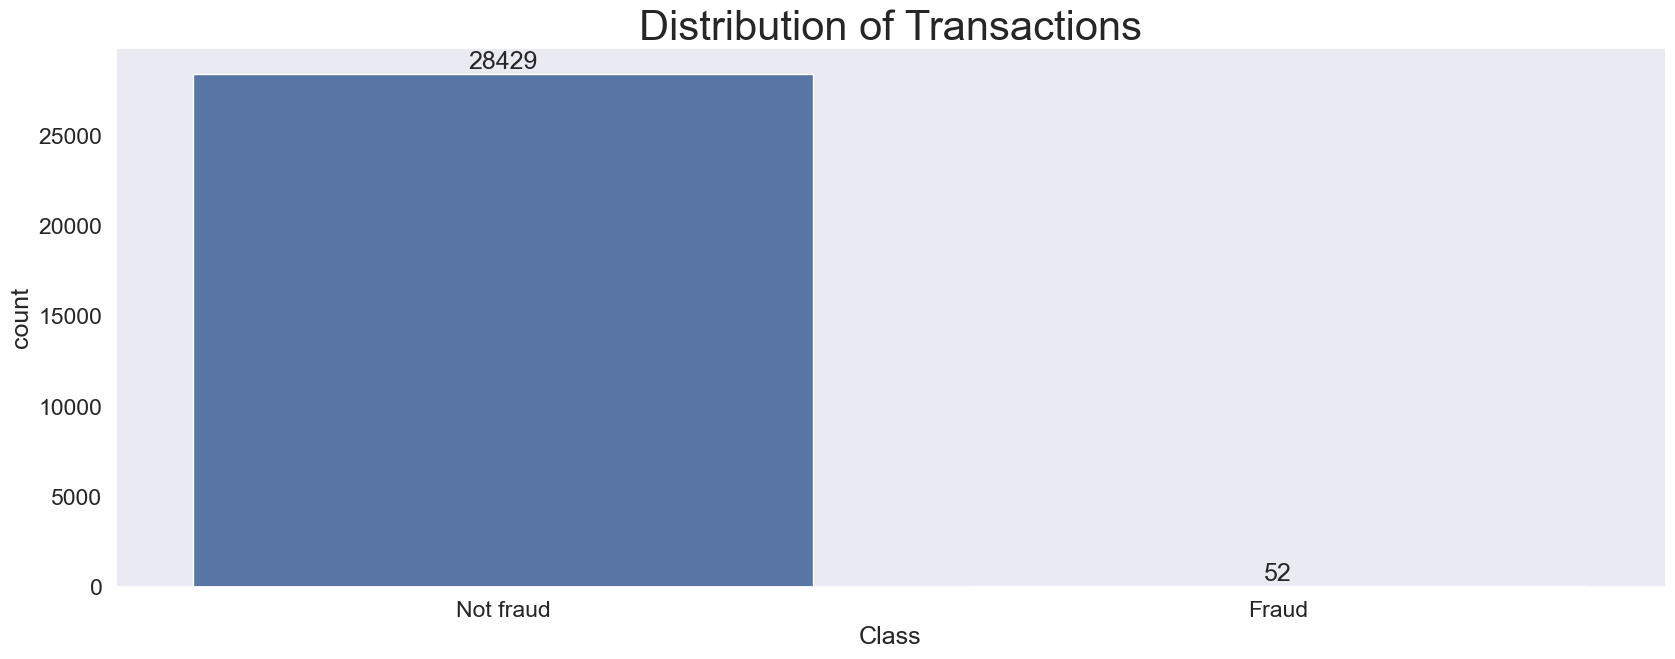

In [140]:
# using seaborns countplot to show distribution of transactions in dataset
ax = sns.countplot(data=df, x="Class")
# add count annotatio to the top of the bars
ax.bar_label(ax.containers[0])  # bar_label available since matplotlib 3.4.0
ax.set_title('Distribution of Transactions', fontsize=30)
ax.set_xticks([0, 1], class_names);


<div class="alert alert-info exercise" >

#### 👉**Exercise** (5 min)

Compute the percentage of fraudulent transactions (ie: when Class == 1)

</div>

In [ ]:
# TODO: Code here

From the plot above, we can see we have a very imbalanced class -  just ~0.18% of our dataset belong to the target class!

This is a problem because many machine learning models are designed to maximize overall accuracy, which especially with imbalanced classes may not be the best metric to use. Classification accuracy is defined as the number of correct predictions divided by total predictions times 100. For example, if we simply predicted all transactions are not fraud, we would get a classification accuracy score of over 99%!



### Create Train and Test Sets

The training set is used to build and validate the model, while the test set is reserved for testing the model on unseen data.

<div class="alert alert-info exercise" >

#### 👉**Exercise** (2 min)

Separate the dataset into `y` and `X`, `y` being the target column and `X` the feature matrix.

</div>

In [ ]:
# Prepare data for modeling
# TODO: Code here
y =
X =


In [5]:
# SOLUTION
X = df.drop(columns="Class")
y = df.Class

Now  let us split this data into a training set and a test set. With imbalanced data, it is important to set `stratify=y` so that all classes get represented in both data splits.

In [6]:

from sklearn.model_selection import train_test_split

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
                                                    stratify=y,random_state=27)

<div class="alert alert-info exercise" >

#### 👉**Exercise** (2 min)

Check the proportion of fraud cases remained the same as before in both training and test splits.

</div>

In [ ]:
# TODO your code here


# Setting-up a "dummy" baseline

To set up a baseline, we are going to use a very simple rule: predict the most frequent class. This `DummyClassifier` can be implemented in scikit-learn as follows:

In [119]:
from sklearn.dummy import DummyClassifier

# DummyClassifier to predict only target 0
dummy = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)

# checking unique labels
print('Unique predicted labels: ', (np.unique(dummy_pred)))

Unique predicted labels:  [0]


As we can see, our Dummy Classifier predicts target == 0 (No fraud) for all the test set. This is surely not a very useful model, despite being quite accurate...


## Evaluating the baseline model

<div class="alert alert-info exercise" >

#### 👉**Exercise** (5 min)

Compute the accuracy of the dummy classifier using two different ways :
*   First with your own code (can be a loop or manipulation of NumPy arrays)
*   Then using `accuracy_score` from `sklearn.metrics`

**Accuracy is the fraction of predictions our model got right. Formally, accuracy has the following definition:**
$$ \text{Accuracy} = \frac{\text{Number of correct predictions}}{\text{Number of total predictions}}$$


In [ ]:
# TODO: Code here
# TODO: accuracy with your own code


# TODO: accuracy with sklearn using sklearn.metrics.accuracy_score

As expected, our accuracy score for classifying all transactions as not fraud is quite high!


# Model 1: linear classification with Logistic Regression
As the Dummy Classifier predicts only Class 0, it is clearly not a good option for our objective of correctly classifying fraudulent transactions.

Let's see how logistic regression performs on this dataset.

In [13]:
from sklearn.linear_model import LogisticRegression

# Modeling the data as is
# Train model
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)
 
# Predict on training set
lr_pred = lr.predict(X_test)

In [122]:
# Checking accuracy
accuracy_score(y_test, lr_pred)

0.9988765622805785

In [123]:
# Checking unique values
predictions = pd.DataFrame(lr_pred)
predictions[0].value_counts()

0
0    7112
1       9
Name: count, dtype: int64

Logistic Regression outperformed the Dummy Classifier!  We can see that it predicted some instances of class 1, so this is definitely an improvement.  But can we do better?

Let's see if we can apply some techniques for dealing with class imbalance to improve these results.


# Techniques without resampling


## 1.  Change the performance metric
Accuracy is not the best metric to use when evaluating imbalanced datasets as it can be misleading.  Metrics that can provide better insight include:
 - **Confusion Matrix:**  a talbe showing correct predictions and types of incorrect predictions.
 - **Precision:**  the number of true positives divided by all positive predictions. Precision is also called Positive Predictive Value. It is a measure of a classifier's exactness. Low precision indicates a high number of false positives.
 - **Recall:**  the number of true positives divided by the number of positive values in the test data. Recall is also called Sensitivity or the True Positive Rate. It is a measure of a classifier's completeness. Low recall indicates a high number of false negatives.
 - **F1: Score:**  the weighted average of precision and recall.
 
Since our main objective with the dataset is to prioritize accuraltely classifying fraud cases the recall score can be considered our main metric to use for evaluating outcomes.<br>

**How do we compute these metrics :**
Let's code these metrics ourselves to make sure we understand what it is.

<div class="alert alert-info exercise" >

#### 👉**Exercise** (10 min)

For the LogisticRegression model, compute true positives (`tp`), false positives (`fp`), false negatives (`fn`), true negatives (`tn`). Here we consider class `1` (fraud) as the positive class (and `0` as the negative one).

Then, use these values to compute the metrics `Precision`, `Recall` and `f1-score`.

You can find the formal definitions here https://en.wikipedia.org/wiki/Confusion_matrix.


</div>

In [ ]:
# TODO: Code here
tp = 
fp =
fn =
tn = 

print(f"True pos: {tp:4d} False pos: {fp:4d}")
print(f"True neg: {tn:4d} False neg: {fn:4d}")

In [ ]:
# TODO: Code here
precision = 
recall = 
f1score = 

print(f"Precision: {precision:0.5f}")
print(f"Recall:    {recall:0.5f}")
print(f"F1:        {f1score:0.5f}")

### **How do we compute these metrics using sklearn:**
Let's see how we compute these metrics using `sklearn.metrics`. We'll do it for the `LogisticRegression`. We need `y_test` which are the real test observations and we need `lr_pred` which are the predictions of the `LogisticRegression` on the test set.

In [103]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score

# Example on LogisticRegression
print('Accuracy is ', accuracy_score(y_test, lr_pred))
print('F1-score is ', f1_score(y_test, lr_pred))
print('Recall is   ', recall_score(y_test, lr_pred))
print('Precision is ', precision_score(y_test, lr_pred))
print('Confusion matrix is (row: true label, col: pred label )')
pd.DataFrame(confusion_matrix(y_test, lr_pred)).head(2)

Accuracy is  0.9988765622805785
F1-score is  0.6363636363636364
Recall is    0.5384615384615384
Confusion matrix is (row: true label, col: pred label )


,0,1
0,7106,2
1,6,7


We have a very high accuracy score of 0.999 but a F1 score of only 0.752.  And from the confusion matrix, we can see we are misclassifying several observations leading to a recall score of only 0.64.


**NOTE** `sklearn` provides a helper function to create a nice plot for the confusion matrix:

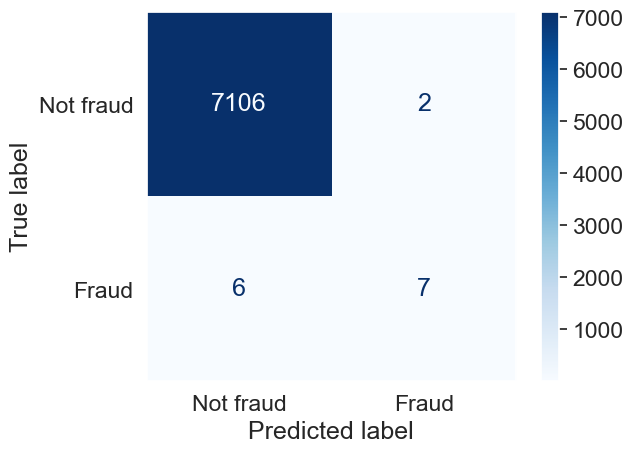

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(
    y_test, lr_pred, display_labels=["Not fraud", "Fraud"],
    cmap="Blues")

It also has a handy function to compute and print multiple metrics at once: `classification_report`

In [15]:
from sklearn.metrics import classification_report

print(classification_report(y_test, lr_pred, 
                            target_names=class_names, digits=3))

              precision    recall  f1-score   support

   Not fraud      0.999     1.000     0.999      7108
       Fraud      0.778     0.538     0.636        13

    accuracy                          0.999      7121
   macro avg      0.888     0.769     0.818      7121
weighted avg      0.999     0.999     0.999      7121




## 2. Change the algorithm
While in every machine learning problem, its a good rule of thumb to try a variety of algorithms, it can be especially beneficial with imbalanced datasets.  Decision trees frequently perform well on imbalanced data.  They work by learning a hierachy of if/else questions.  This can force both classes to be addressed.




<div class="alert alert-info exercise" >

#### 👉**Exercise** (5 min)

Use a [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) with `n_estimators=10` and compute the usual metrics (accuracy, f1-score, recall and confusion matrix)

</div>

In [ ]:
# TODO: Code here

# Resampling Techniques

## 3. Oversampling Minority Class
Oversampling can be defined as adding more copies of the minority class.  Oversampling can be a good choice when you don't have a ton of data to work with.  A con to consider when undersampling is that it can cause overfitting and poor generalization to your test set.

We will use the resampling module from Scikit-Learn to randomly replicate samples from the minority class.


In [135]:
from sklearn.utils import resample

<div class="alert alert-warning">

##### **⚠ Important Note**
Always split into test and train sets BEFORE trying any resampling techniques!  Oversampling before splitting the data can allow the exact same observations to be present in both the test and train sets!  This can allow our model to simply memorize specific data points and cause overfitting.

</div>

We have already split our data in training and testing sets. So now we proceed to resampling the training set in order to augment the proportion of "Fraud" cases. We need to follow four steps:
1. Concatenate `X_train` and `y_train` back together.
2. Split training data into fraud and not-fraud cases.
3. Resample (with replacement) the fraud cases to increase their quantity.
4. Concatenate upsampled data with non-fraud data.

The code cells bellow do just that:

In [136]:
# concatenate our training data back together
Xy_train = pd.concat([X_train, y_train], axis=1)
Xy_train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
12108,162925.0,-0.203339,0.745119,0.017504,0.473495,0.797758,-0.986894,0.664523,-0.127849,-0.052009,...,0.101933,0.495382,-0.201071,-0.108282,-0.426780,0.741579,0.160000,0.217214,10.00,0
18762,96775.0,2.021803,-0.296038,-1.284361,0.189496,0.264774,-0.008091,-0.252052,-0.079742,2.257106,...,-0.051069,0.306519,0.007369,0.268901,0.205378,0.129936,-0.067867,-0.074949,19.00,0
27642,65679.0,-0.169869,0.366543,2.447907,0.079963,-0.501969,0.004453,0.503431,-0.422667,0.696724,...,-0.183859,0.103784,-0.066130,0.501324,-0.835188,0.831238,-0.314123,-0.295409,30.00,0
25697,76650.0,1.257732,0.404766,0.320691,0.686592,-0.311370,-1.057560,0.131736,-0.241928,-0.069273,...,-0.280163,-0.774555,0.121742,0.363754,0.239005,0.092203,-0.018583,0.032183,1.29,0
8891,20718.0,1.033414,0.039568,1.535109,2.959329,-0.491583,1.085995,-0.745403,0.178111,1.766338,...,-0.268127,-0.281187,-0.160942,-0.470993,0.482591,0.037972,0.030157,0.033921,63.76,0


In [137]:
# separate minority and majority classes
not_fraud = Xy_train[Xy_train.Class==0]
fraud = Xy_train[Xy_train.Class==1]

# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproductible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled.Class.value_counts()

Class
0    21321
1    21321
Name: count, dtype: int64


<div class="alert alert-info exercise" >

#### 👉**Exercise** (8 min)

Train a model (`LogisticRegression` for example) on the `upsampled` data and compute the usual metrics.

_Tip_: you need to split `upsampled` back into features `X` and targets `y`. Give them new names so they dont overwrite existing `X` and `y` variables.

</div>

In [ ]:
# TODO: Code here


<div class="alert exercise" >

#### ❓ **Question** 
Compare the results with what we have seen before. Do we get more precise in detecting frauds? Can we safely detect a larger portion of the fraud cases?

</div>


**Answer here** :



## 4. Undersampling Majority Class
Undersampling can be defined as removing some observations of the majority class.  Undersampling can be a good choice when you have a ton of data -think millions of rows.  But a drawback to undersampling is that we are removing information that may be valuable.

We will again use the resampling module from Scikit-Learn to randomly remove samples from the majority class. 

We'll work the same steps we did for upsampling, though we can reuse some of the variables previously created.

In [146]:
# still using our separated classes fraud and not_fraud from above

# downsample majority
not_fraud_downsampled = resample(not_fraud,
                                replace = False, # sample without replacement
                                n_samples = len(fraud), # match minority n
                                random_state = 27) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([not_fraud_downsampled, fraud])

# checking counts
downsampled.Class.value_counts()

Class
0    39
1    39
Name: count, dtype: int64


<div class="alert alert-info exercise" >

#### 👉**Exercise** (5 min)

Train a model (`LogisticRegression` for example) on the `downsampled` data and compute the usual metrics.

_Tip_: you need to split `downsampled` back into features `X` and targets `y`. Give them new names so they dont overwrite existing `X` and `y` variables.

</div>

In [ ]:
# TODO: Code here


<div class="alert exercise" >

#### ❓ **Question** 
Compare the results with what we have seen before. Do we get more precise in detecting frauds? Can we safely detect a larger portion of the fraud cases?

</div>


**Answer here** :



## 5. Generate Synthetic Samples
SMOTE or Synthetic Minority Oversampling Technique is a popular algorithm to creates sythetic observations of the minority class.

We are going to use the implementation from the 
[`imblearn` package](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html).
First we need to create a `SMOTE` instance. 

In [10]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy=1.0, random_state=27)

To do the sample generation, we call `.fit_resample` and give our original training data as arguments:

In [ ]:

X_smote, y_smote = sm.fit_resample(X_train, y_train)

The generated dataset will have a balanced distribution of both classes:

In [11]:
print(y_smote.value_counts())

Class
0    21321
1    21321
Name: count, dtype: int64



<div class="alert alert-info exercise" >

#### 👉**Exercise** (5 min)

Train a model (`LogisticRegression` for example) on the `SMOTE` data and compute the usual metrics.

</div>

In [ ]:
# TODO: Code here


<div class="alert exercise" >

#### ❓ **Question** 
Compare the results with what we have seen before. Do we get more precise in detecting frauds? Can we safely detect a larger portion of the fraud cases?

</div>


**Answer here** :



# Conclusion

We covered 5 different methods for dealing with imbalanced datasets:
1.  Change the performance metric
2.  Oversampling minority class
3.  Undersampling majority class
4.  Change the algorithm
5.  Generate synthetic samples

These are just some of the many possible methods to try when dealing with imbalanced datasets, and not an exhaustive list.  Some others methods to consider are collecting more data or choosing different resampling ratios - you don't have to have exactly a 1:1 ratio!  You should always try several approaches and then decide which is best for your problem.